# 📌 Project Overview: Customer Segmentation Using RFM Clustering
In this project, we aim to segment customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis and clustering techniques.

🎯 Objective:

* Understand how customers interact with the online retail store.

* Segment them into meaningful groups for targeted marketing and business strategy.

* Derive actionable insights from unsupervised learning (e.g., K-Means clustering).

🧠 Key Skills Demonstrated:

* Real-world data cleaning & wrangling

* Feature engineering using RFM metrics

* Clustering with K-Means

* Cluster validation using silhouette scores

* Data visualization and business insight derivation



### Step 1: Load and Clean Data

We begin by importing the Online Retail dataset, which includes transactions from a UK-based e-commerce company between 2010–2011.

To ensure clean data:
- Removed entries without `CustomerID`
- Dropped canceled transactions (InvoiceNo starting with "C")
- Filtered only positive `Quantity` and `UnitPrice`
- Calculated `TotalPrice = Quantity * UnitPrice`


In [1]:
import pandas as pd

# Load Excel file
df = pd.read_excel('/content/Online Retail.xlsx')

# Initial shape and nulls
print("Initial shape:", df.shape)
print("Nulls per column:\n", df.isnull().sum())

# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove canceled orders (those with InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)

# Final cleaned shape
print("Cleaned shape:", df.shape)


Initial shape: (541909, 8)
Nulls per column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Cleaned shape: (397884, 9)


### Step 2: Feature Engineering - RFM

To segment customers, we compute three key RFM metrics:

- **Recency**: How recently a customer made a purchase
- **Frequency**: How often the customer makes a purchase
- **Monetary**: How much money the customer has spent

These values are aggregated per `CustomerID` and form the basis for clustering.


In [2]:
# Use the max invoice date as reference point for recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### Step 3: Normalize RFM & Cluster Using K-Means

We standardize the RFM features using **StandardScaler** so that each metric contributes equally to the clustering process.

To determine the optimal number of clusters (K), we use:

- **Elbow Method**: Checks the rate of decrease in SSE (distortion)
- **Silhouette Score**: Measures how well each point fits within its cluster

These help us balance underfitting vs overfitting in unsupervised clustering.


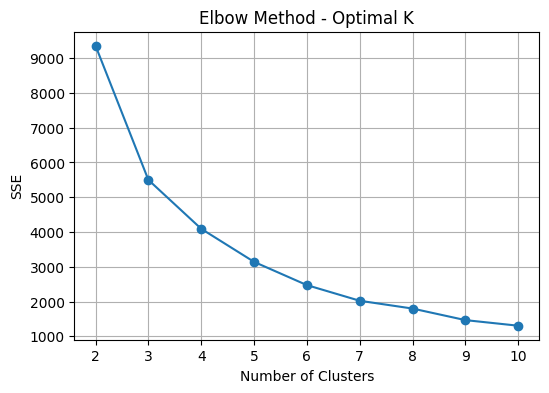

Silhouette Score for k=2: 0.5604
Silhouette Score for k=3: 0.5853
Silhouette Score for k=4: 0.6162
Silhouette Score for k=5: 0.6171
Silhouette Score for k=6: 0.5983


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Normalize RFM features
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)

# 2. Elbow method to determine k
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(6,4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

# Silhouette scores
for k in [2, 3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, preds)
    print(f"Silhouette Score for k={k}: {score:.4f}")


### Step 4: Assign Clusters & Analyze Segments

We applied K-Means clustering with the optimal number of clusters (k=5) based on the silhouette score. Each customer was assigned to a segment based on their RFM score. We then profiled each segment to understand key characteristics such as average recency, frequency, and monetary values.

To further interpret the segmentation, we visualized the clusters using PCA. This dimensionality reduction technique helped us see how distinct the segments are in a 2D space.

These insights can guide targeted marketing, customer retention strategies, and personalization efforts.


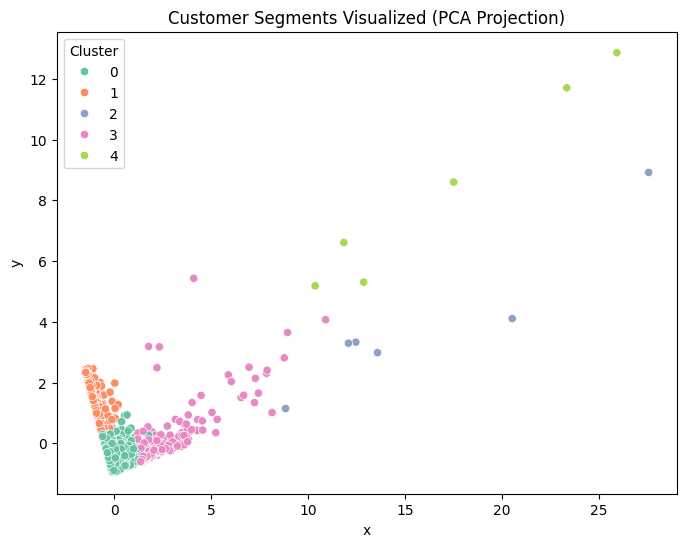

In [7]:
from sklearn.cluster import KMeans

# Fit with k=5 (chosen based on silhouette score)
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Average RFM values for each cluster
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(1)

cluster_profile

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)
rfm['x'] = components[:, 0]
rfm['y'] = components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='x', y='y', hue='Cluster', palette='Set2')
plt.title('Customer Segments Visualized (PCA Projection)')
plt.show()


## 🧠 Customer Segmentation Using Clustering

### 📊 Objective:
To segment retail customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis and unsupervised machine learning. This segmentation enables better marketing targeting, customer retention, and business strategy.

---

### ✅ Project Steps:

1. **Data Preprocessing:**
   - Removed missing CustomerIDs and invalid transactions (e.g., refunds, negative quantities/prices).
   - Final dataset size: ~397,000 transactions.

2. **RFM Feature Engineering:**
   - **Recency:** Days since last purchase.
   - **Frequency:** Number of transactions.
   - **Monetary:** Total amount spent.
   - Created a customer-level RFM table.

3. **Clustering with K-Means:**
   - Scaled RFM features using `StandardScaler`.
   - Used `Silhouette Score` to find the optimal number of clusters → best at **k=5**.
   - Applied K-Means clustering to segment customers.

4. **PCA Visualization:**
   - Reduced RFM dimensions to 2D using PCA.
   - Plotted clusters to visualize separability and structure.

---

### 🔍 Key Segment Profiles (k=5):

| Cluster | Characteristics                              | Suggested Action                     |
|---------|-----------------------------------------------|--------------------------------------|
| 0       | Low Recency, Medium Frequency & Spend         | Engaged customers, keep nurturing    |
| 1       | High Frequency, Medium-High Monetary          | Loyal customers, reward with perks   |
| 2       | Low Frequency, High Spend                     | Big spenders, offer exclusive deals  |
| 3       | Medium Recency, Medium Frequency & Spend      | Casual shoppers, send reactivation   |
| 4       | Very high Recency, very low Frequency/Spend   | Lost customers, try win-back offers  |

---

### 💡 Business Value:
- Enables **personalized marketing** (emails, offers).
- Identifies **VIPs**, **at-risk**, and **inactive** customers.
- Supports **resource prioritization** in campaigns.

